Starting episode 1
No vehicles left, terminating simulation.
Episode 1 finished with total reward: 369222.53
Starting episode 2
No vehicles left, terminating simulation.
Episode 2 finished with total reward: 363471.34
Starting episode 3
No vehicles left, terminating simulation.
Episode 3 finished with total reward: 365953.94
Starting episode 4
No vehicles left, terminating simulation.
Episode 4 finished with total reward: 364575.30
Starting episode 5
No vehicles left, terminating simulation.
Episode 5 finished with total reward: 367111.11
Starting episode 6
No vehicles left, terminating simulation.
Episode 6 finished with total reward: 366906.52
Starting episode 7
No vehicles left, terminating simulation.
Episode 7 finished with total reward: 365608.82
Starting episode 8
No vehicles left, terminating simulation.
Episode 8 finished with total reward: 367413.74
Starting episode 9
No vehicles left, terminating simulation.
Episode 9 finished with total reward: 368296.92
Starting episode 10

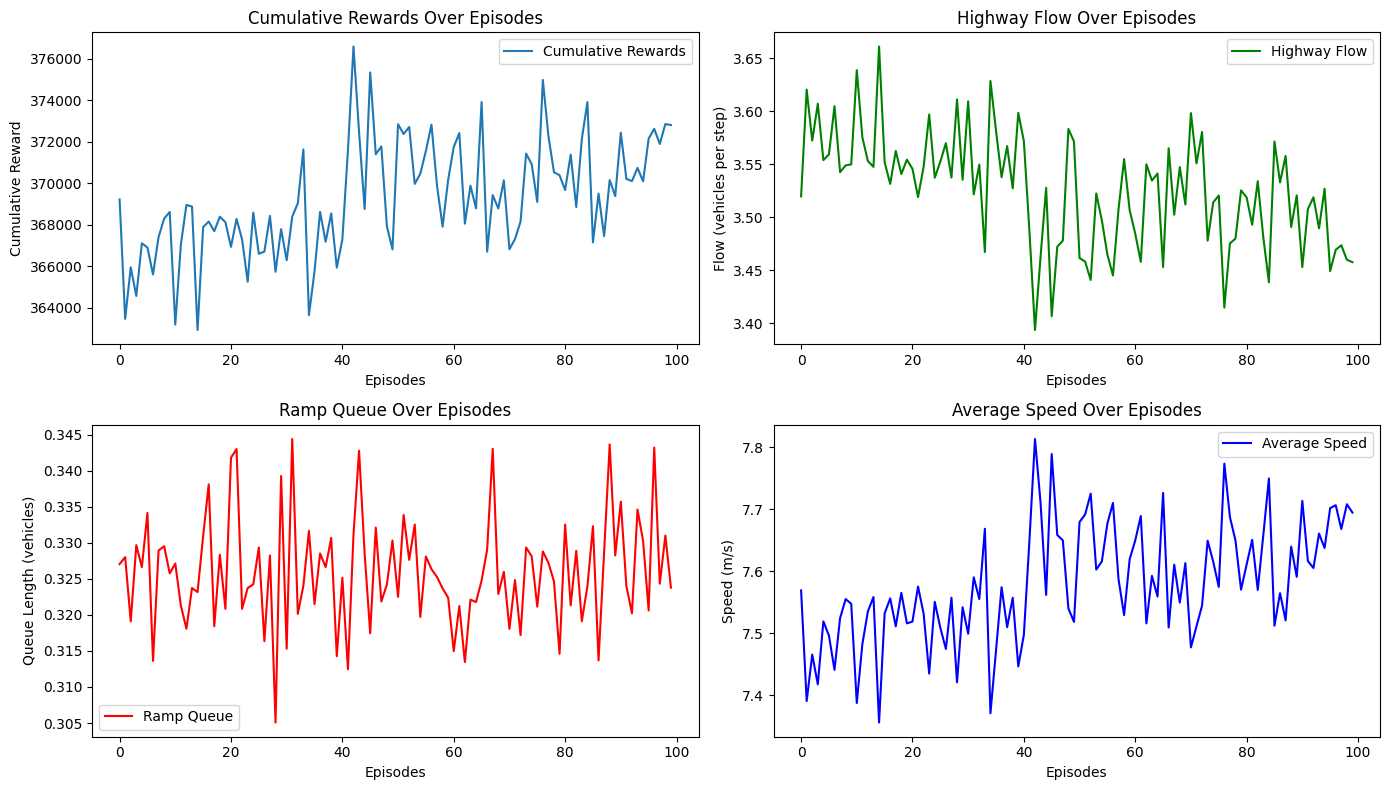

: 

In [ ]:
import traci
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque

# Hyperparameters
ALPHA = 0.1  # Learning rate
GAMMA = 0.95  # Discount factor
EPSILON = 1  # Initial exploration rate
EPSILON_DECAY = 0.01  # Epsilon decay rate
MIN_EPSILON = 0.001  # Minimum exploration rate
NUM_EPISODES = 100
CONVERGENCE_THRESHOLD = 1e-3
REPLAY_BUFFER_SIZE = 1000
BATCH_SIZE = 32

# Initialize Q-table
num_states_traffic = 11
num_states_queue = 11
num_actions = 3
q_table = np.zeros((num_states_traffic, num_states_queue, num_actions))

# Replay buffer for experience replay
replay_buffer = deque(maxlen=REPLAY_BUFFER_SIZE)

# Helper functions
def reset_simulation():
    """Reset the SUMO simulation to the starting point."""
    traci.load(["--net-file", "test1.net.xml", "--route-files", "test1.rou.xml", "--additional-files", "test1.add.xml"])
    return get_state()

def get_state():
    """Retrieve the current state of the system."""
    highway_traffic = min(traci.edge.getLastStepVehicleNumber("E0") / 10, 1)  # Normalize to [0, 1]
    ramp_queue = min(traci.edge.getLastStepVehicleNumber("E2") / 10, 1)  # Normalize to [0, 1]
    traffic_light_phase = traci.trafficlight.getPhase("J1")
    return (highway_traffic, ramp_queue, traffic_light_phase)

def calculate_reward(highway_flow, ramp_queue, avg_speed):
    """Calculate the reward with refined scaling."""
    highway_reward = 10.0 * np.log1p(highway_flow)  # Logarithmic scaling
    speed_reward = 5.0 * avg_speed  # Moderate weight for speed
    queue_penalty = -5.0 * ramp_queue  # Heavier penalty for ramp queue
    reward = highway_reward + speed_reward + queue_penalty
    return reward

def select_action(state, epsilon):
    """Select an action using epsilon-greedy policy with weighted adjustments."""
    if np.random.rand() < epsilon:
        return np.random.choice([0, 1, 2])  # Explore: random action
    else:
        state_indices = (
            max(0, min(int(state[0] * 10), q_table.shape[0] - 1)),
            max(0, min(int(state[1] * 10), q_table.shape[1] - 1)),
            max(0, min(state[2], q_table.shape[2] - 1)),
        )
        q_values = q_table[state_indices[0], state_indices[1], :]
        
        # Debugging: Validate q_values shape
        if q_values.ndim != 1:
            raise ValueError(f"Expected q_values to be 1D, got shape {q_values.shape}. Check state indices: {state_indices}")
        
        weights = [1.2 if i == np.argmax(q_values) else 1.0 for i in range(len(q_values))]
        return random.choices(range(len(q_values)), weights=weights)[0]  # Weighted action selection


def take_action(action):
    """Take the action in the simulation and return the new state and reward."""
    traci.trafficlight.setPhase("J1", action)  # Set traffic light phase

    if traci.simulation.getMinExpectedNumber() > 0:  # Check for active vehicles
        traci.simulationStep()
    else:
        print("No vehicles left, terminating simulation.")
        return None, 0, True  # End episode if no vehicles remain

    # Get new state
    next_state = get_state()
    highway_flow = traci.edge.getLastStepVehicleNumber("E0")
    ramp_queue = traci.edge.getLastStepVehicleNumber("E2")
    avg_speed = traci.edge.getLastStepMeanSpeed("E0")  # Average speed on highway
    reward = calculate_reward(highway_flow, ramp_queue, avg_speed)

    done = False
    return next_state, reward, done

def update_q_table(state, action, reward, next_state):
    """Update the Q-table using the Q-learning formula."""
    if next_state is None:
        return

    state_indices = (
        max(0, min(int(state[0] * 10), q_table.shape[0] - 1)),
        max(0, min(int(state[1] * 10), q_table.shape[1] - 1)),
        max(0, min(state[2], q_table.shape[2] - 1))
    )
    next_state_indices = (
        max(0, min(int(next_state[0] * 10), q_table.shape[0] - 1)),
        max(0, min(int(next_state[1] * 10), q_table.shape[1] - 1)),
        max(0, min(next_state[2], q_table.shape[2] - 1))
    )

    max_future_q = np.max(q_table[next_state_indices[0], next_state_indices[1], :])
    current_q = q_table[state_indices[0], state_indices[1], action]
    q_table[state_indices[0], state_indices[1], action] += ALPHA * (reward + GAMMA * max_future_q - current_q)

def replay_experience():
    """Perform experience replay to stabilize learning."""
    if len(replay_buffer) < BATCH_SIZE:
        return

    batch = random.sample(replay_buffer, BATCH_SIZE)
    for state, action, reward, next_state in batch:
        update_q_table(state, action, reward, next_state)

# Run simulation
sumo_binary = "sumo"
sumo_config_file = "test1.sumocfg"
traci.start([sumo_binary, "-c", sumo_config_file])

# Run Simulation with Improved Exploration and Exploitation
cumulative_rewards = []
highway_flows = []
ramp_queues = []
avg_speeds = []

for episode in range(NUM_EPISODES):
    print(f"Starting episode {episode + 1}")
    total_reward = 0
    state = reset_simulation()
    done = False

    q_table_prev = q_table.copy()  # Copy for convergence check
    episode_highway_flows = []
    episode_ramp_queues = []
    episode_speeds = []

    while not done:
        if state is None:
            done = True
            break

        action = select_action(state, EPSILON)
        next_state, reward, done = take_action(action)
        total_reward += reward

        if next_state is None:
            done = True
            break

        replay_buffer.append((state, action, reward, next_state))
        update_q_table(state, action, reward, next_state)
        state = next_state

        # Track metrics
        highway_flow = traci.edge.getLastStepVehicleNumber("E0")
        ramp_queue = traci.edge.getLastStepVehicleNumber("E2")
        avg_speed = traci.edge.getLastStepMeanSpeed("E0")
        episode_highway_flows.append(highway_flow)
        episode_ramp_queues.append(ramp_queue)
        episode_speeds.append(avg_speed)

        replay_experience()  # Perform experience replay

    # Aggregate metrics for the episode
    highway_flows.append(np.mean(episode_highway_flows))
    ramp_queues.append(np.mean(episode_ramp_queues))
    avg_speeds.append(np.mean(episode_speeds))

    # Convergence Check
    max_change = np.max(np.abs(q_table - q_table_prev))
    if max_change < CONVERGENCE_THRESHOLD:
        print(f"Convergence reached at episode {episode + 1} (Q-table change: {max_change:.6f})")
        break

    # Decay Epsilon
    EPSILON = max(MIN_EPSILON, EPSILON * (1 - EPSILON_DECAY))

    cumulative_rewards.append(total_reward)
    print(f"Episode {episode + 1} finished with total reward: {total_reward:.2f}")

traci.close()

# Plot Results
plt.figure(figsize=(14, 8))

# Cumulative Rewards
plt.subplot(2, 2, 1)
plt.plot(cumulative_rewards, label="Cumulative Rewards")
plt.title("Cumulative Rewards Over Episodes")
plt.xlabel("Episodes")
plt.ylabel("Cumulative Reward")
plt.legend()

# Highway Flow
plt.subplot(2, 2, 2)
plt.plot(highway_flows, label="Highway Flow", color="green")
plt.title("Highway Flow Over Episodes")
plt.xlabel("Episodes")
plt.ylabel("Flow (vehicles per step)")
plt.legend()

# Ramp Queue
plt.subplot(2, 2, 3)
plt.plot(ramp_queues, label="Ramp Queue", color="red")
plt.title("Ramp Queue Over Episodes")
plt.xlabel("Episodes")
plt.ylabel("Queue Length (vehicles)")
plt.legend()

# Average Speed
plt.subplot(2, 2, 4)
plt.plot(avg_speeds, label="Average Speed", color="blue")
plt.title("Average Speed Over Episodes")
plt.xlabel("Episodes")
plt.ylabel("Speed (m/s)")
plt.legend()

plt.tight_layout()
plt.show()
